# Performance Benchmarks

The ``fast_hdbscan`` library is not as featureful as the classic ``hdbscan`` library, and certainly can't handle the diversity of data inputs that ``hdbscan`` can. However the case where it can shine is in modern multicore systems with low-dimensional data. What counts as low dimensional? We'll look at that in this notebook. First, however, let's load some libraries.

In [1]:
import numpy as np
import pandas as pd
import sklearn.datasets
import seaborn as sns
import matplotlib.pyplot as plt
import time

import hdbscan
import fast_hdbscan

sns.set(rc={"figure.figsize":(8, 8)})

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


To make things easily repeatable we'll write a simple benchmarking function that can time how long it takes the different HDBSCAN implementations to run on the same randomly generated dataset. To generate the datasets we'll just use ``make_blobs`` from sklearn. This will not produce the most interesting datasets for clustering, but it will be good enough to benchmark runtimes. Since we will be interested in varying the dimension of the dataset we'll leave that as a parameter, and we'll scale the size of the blobs accordingly (there is more space in high dimensions so we can have a larger standard deviation on the blobs) to make it more realistic.

In [2]:
def benchmark(
    n_samples_vals,
    dimension=2, 
    n_clusters=100, 
    n_runs=5, 
    min_samples=10, 
    min_cluster_size=100
):
    rows = []
    for n_samples in n_samples_vals:
        min_cluster_size = min(n_samples // n_clusters, min_cluster_size)
        for n in range(n_runs):
            data_sample, _ = sklearn.datasets.make_blobs(
                n_samples=n_samples, 
                n_features=dimension,
                centers=n_clusters,
                cluster_std=min((10**dimension / (n_clusters * 9)), 2.0)
            )
            for hdbscan_module in (hdbscan, fast_hdbscan):
                start_time = time.time()
                model = hdbscan_module.HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size)
                cluster_labels = model.fit_predict(data_sample)
                elapsed = time.time() - start_time
                rows.append((hdbscan_module.__name__, n_samples, n, elapsed))
    
    return pd.DataFrame(rows, columns=("algorithm", "n_samples", "run", "elapsed_time"))

With that in hand we can just run a benchmark. For reference this notebook was run on an 8-core machine. If you have fewer cores you'll see less improvement, and if you have more cores, well, things will only look better. To start we'll use simple two dimensional data, which is the best case. We'll see how performance scales starting from 10000 data samples, all the way up to a little over a million samples.

In [3]:
benchmark_results = benchmark([10000, 20000, 40000, 80000, 160000, 320000, 640000, 1280000])

Plotting the results we can see that for large data set sizes we are seeing significant gains for the ``fast_hdbscan`` library!

Text(0.5, 1.0, 'Scaling comparison of hdbscan and fast_hdbscan on 2D data')

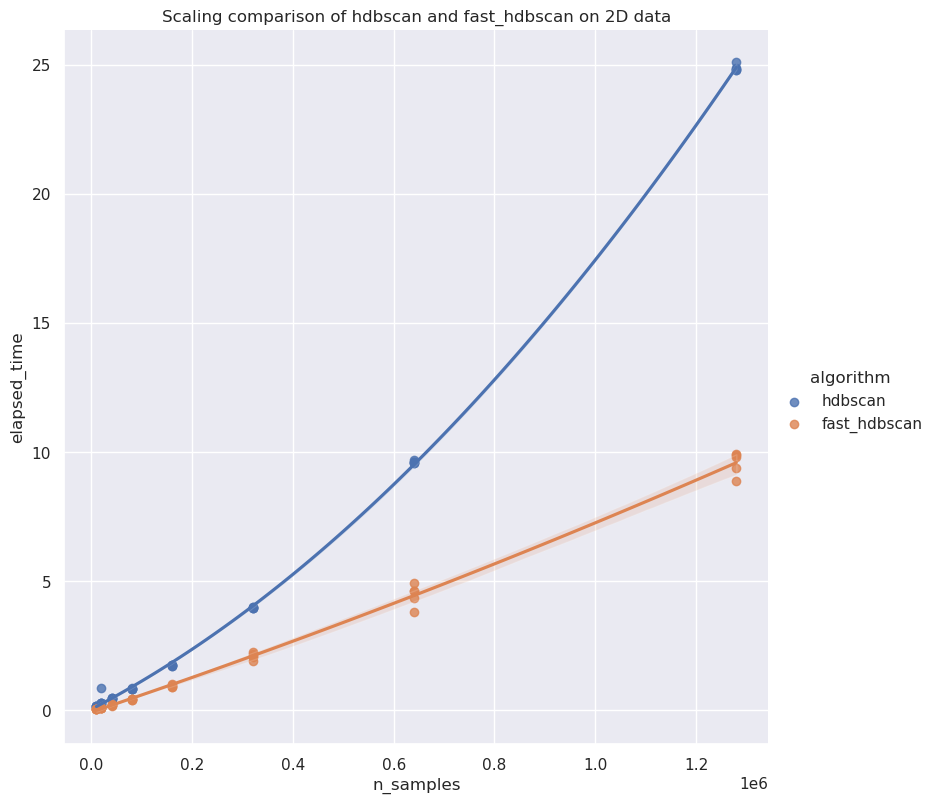

In [4]:
sns.lmplot(benchmark_results, x="n_samples", y="elapsed_time", hue="algorithm", height=8, order=2)
plt.title("Scaling comparison of hdbscan and fast_hdbscan on 2D data")

Let's scale up the dimension a little. We'll try ten dimensional data. Since this makes both implementations work harder we'll scale back how large a data set we will try to avoid spending too much time just running the benchmark.

In [5]:
benchmark_results_10d = benchmark([10000, 20000, 40000, 80000, 160000, 320000], dimension=10)

Plotting the results we see that we are still getting significant gains for ten dimensional data; we can see, however, that the ``fast_hdbscan`` curve is starting to bend a little more, and as we scale out to larger dataset sizes this will definitely com into play eventually.

Text(0.5, 1.0, 'Scaling comparison of hdbscan and fast_hdbscan on 10D data')

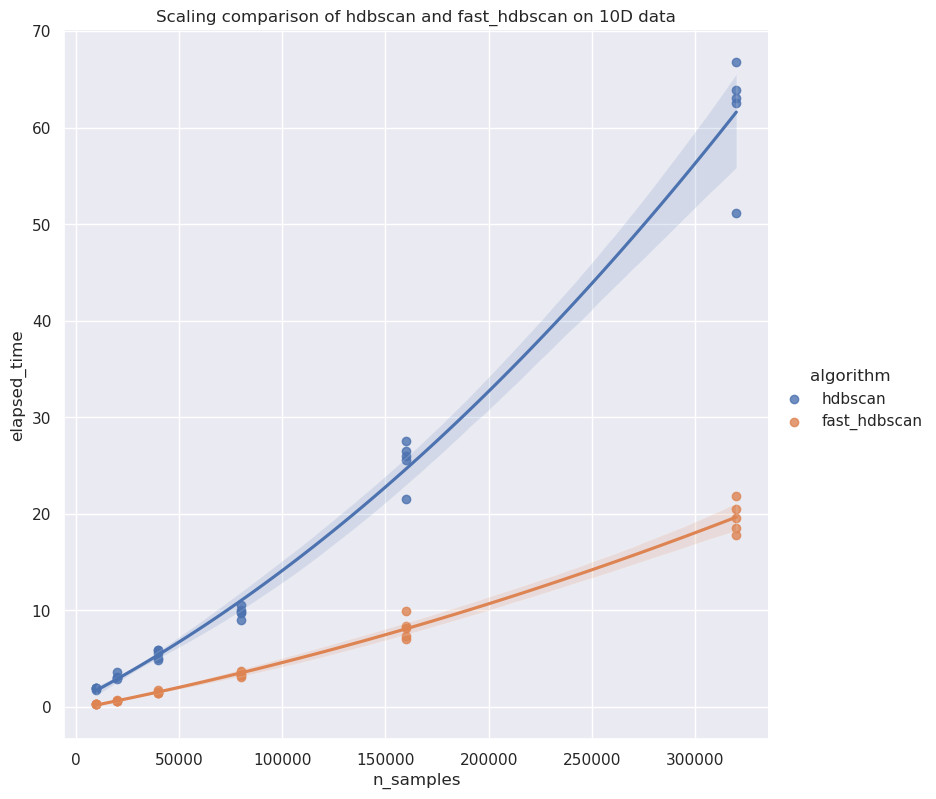

In [6]:
sns.lmplot(benchmark_results_10d, x="n_samples", y="elapsed_time", hue="algorithm", height=8, order=2)
plt.title("Scaling comparison of hdbscan and fast_hdbscan on 10D data")

Lastly let's try twenty dimensional data. Again, with the higher dimension, both implementation will struggle more, so we will again reduce the maximum dataset size we'll scale to.

In [7]:
benchmark_results_20d = benchmark([5000, 10000, 20000, 40000, 80000], dimension=20)

Plotting the results we see that we are coming to the end of the performance advantages for the parallel algorithm approach. The techniques used to allow efficient paralellism of HDBSCAN computation start to become increasingly less efficient in higher dimensions. In contrast the class ``hdbscan`` has  avriety of algorithms that, while unable to be easily parallelised, do scale much better with dimension. So, the answer to our question: what counts as low dimensional? Anything less than twenty dimensions is probably good. Of course a lot will depend on hardware etc. so your mileage may vary.

Text(0.5, 1.0, 'Scaling comparison of hdbscan and fast_hdbscan on 20D data')

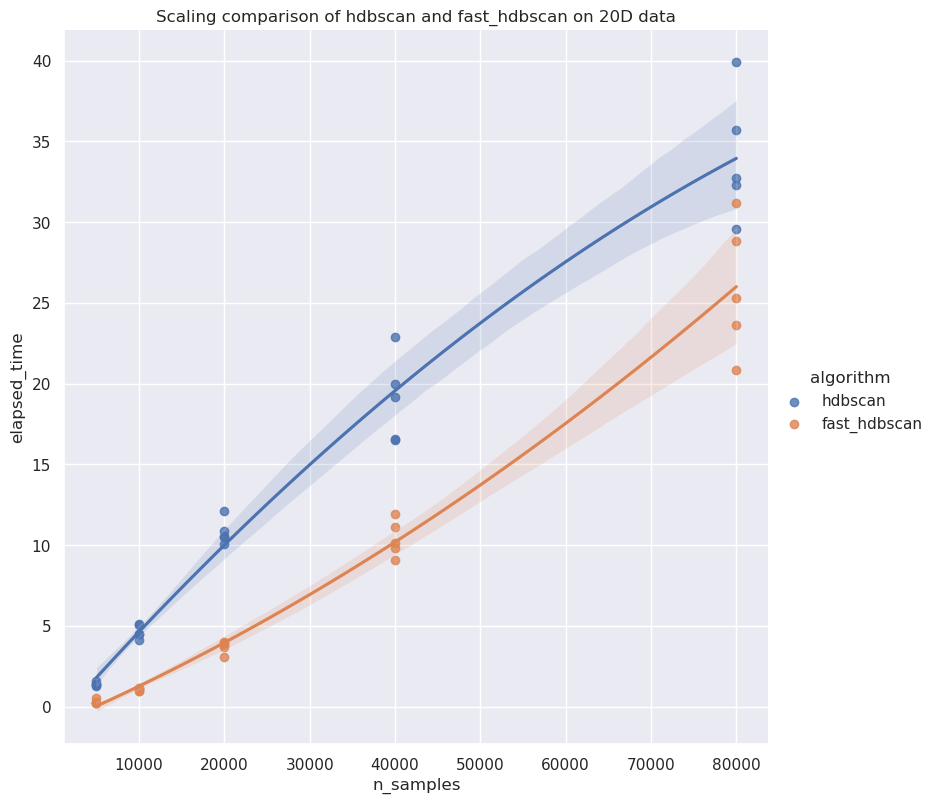

In [8]:
sns.lmplot(benchmark_results_20d, x="n_samples", y="elapsed_time", hue="algorithm", height=8, order=2)
plt.title("Scaling comparison of hdbscan and fast_hdbscan on 20D data")